# Known Cancer Predisposition from Combined data with out autosomal recessive
-----
- Date : 31th May 2019
- using R3.5 kernal
- on 89
-----
- Aim : 
1. subset out the known cancer predisposition gene == known
   - known	290
   - suggesting	2726
2. Check how many samples these variants belong to
   - 290 variants coming from 262 Tumor_Sample_Barcode
   - these 290 variants coming from 83 Hugo_Symbol
3. intersect 371 Tumor_Sample_Barcode with Tumor_Sample_Barcode of clinical data
   - out of 371 only 366 intersected 
   - why those other five samples not in clinical data
   
   - Rerun on 17th May 2019

In [1]:
source("~/bin/da.R")

In [2]:
suppressPackageStartupMessages({
    library(tidyverse) 
    library(vcd)
    library(readr)
    library(maftools)
    library(corrplot)
    library(knitr)
    library(wordcloud)
    library(RColorBrewer)})

In [3]:
packageVersion("maftools")

[1] ‘1.8.0’

## Load Mutation Data and subset

In [4]:
file_name="../KCPG_Variants/data/Mutation_data_cleaned_051019.xls"

In [5]:
df = readxl::read_excel(file_name)

In [6]:
df %>% dim

[1] 3016   84

In [7]:
knitr::kable( sort( table(df$Tumor_types ),decreasing = T), format="pandoc")



Var1     Freq
------  -----
CNS       613
WLM       405
NBL       343
RHB       259
OS        241
HGG       229
RB        221
EWS       192
STS       177
GCT       139
ACT        79
LGG        52
CA         35
OST        18
RCC         5
GICT        2
LMPRT       2
PGL         2
BCC         1
NM          1

In [8]:
cbind( df$Known_Cancer_Predisposition_Genes %>% table )

known,290
suggesting,2726


In [9]:
df = df[df$Known_Cancer_Predisposition_Genes == 'known',]
df =droplevels(df)

In [10]:
df%>% dim

[1] 290  84

In [11]:
df$Mode_of_Inheritance_abb %>% table

.
   AD    AR AR/AD   XLD 
  153    92    43     2 

In [12]:
table(df$Mode_of_Inheritance_abb , df$genotype)

       
        Het Hom
  AD    153   0
  AR     92   0
  AR/AD  43   0
  XLD     1   1

In [13]:
df = df[df$Mode_of_Inheritance_abb != 'AR',]
df =droplevels(df)

In [14]:
df %>% dim

[1] 198  84

In [15]:
# sanity check
df$Mode_of_Inheritance_abb %>% table

.
   AD AR/AD   XLD 
  153    43     2 

In [16]:
len( unique(df$Tumor_Sample_Barcode) )

[1] 182

In [17]:
len( unique(df$Hugo_Symbol) )

[1] 54

### Note :
- there are 54 genes from 182 samples and 198 variants

## Load Clinical Data

In [18]:
file_name_clinical = "../KCPG_Variants/data/Combined_Clinical_Data_03.xlsx"

In [19]:
df2 = readxl::read_excel( file_name_clinical )

In [20]:
df2 %>% head

Tumor_Sample_Barcode,Tumor_type,Tumor_type2,Age_of_Onset,Sex,Age_group,sample_type,sequencing_type,Access_unit,Status,Ethnicity,Race
SJACT014,Adrenocortical Carcinoma,ACT,0.9138889,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT019118,Adrenocortical Carcinoma,ACT,1.0200000,Female,Children,germline,WES,SJLIFE,live,"Non Spanish speaking, Non Hispanic",NA
SJACT025,Adrenocortical Carcinoma,ACT,1.0833333,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT018,Adrenocortical Carcinoma,ACT,1.0833333,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT010,Adrenocortical Carcinoma,ACT,1.1138889,Male,Children,germline,WES,PCGP,live,NA,NA
SJACT016,Adrenocortical Carcinoma,ACT,1.2611111,Male,Children,germline,WES,PCGP,live,NA,NA


In [21]:
df2 %>% dim

[1] 1507   12

In [22]:
len( intersect( unique(df$Tumor_Sample_Barcode), unique(df2$Tumor_Sample_Barcode) ) )

[1] 182

In [23]:
setdiff( df$Tumor_Sample_Barcode, df2$Tumor_Sample_Barcode )

character(0)

In [24]:
table( df$Tumor_Sample_Barcode %in% intersect( df$Tumor_Sample_Barcode, df2$Tumor_Sample_Barcode )) 


TRUE 
 198 

In [25]:
## subset df where samples from df and df2 are same

In [26]:
ss = df$Tumor_Sample_Barcode %in% intersect( df$Tumor_Sample_Barcode, df2$Tumor_Sample_Barcode )

In [27]:
df_ss = df[ ss, ]

In [28]:
df_ss %>% dim

[1] 198  84

In [29]:
table(df_ss$Tumor_types, useNA = "always")


 ACT  CNS  EWS  GCT  HGG  LGG  NBL   OS  OST   RB  RHB  STS  WLM <NA> 
  11   47    8    5    8    2   19   13    2   44   11    6   22    0 

In [30]:
table(df_ss$Known_Cancer_Predisposition_Genes, useNA = "always")


known  <NA> 
  198     0 

In [31]:
cbind(dim(df_ss), dim(df2))

198,1507
84,12


In [32]:
df_ss %>% dim

[1] 198  84

In [33]:
df2 %>% dim

[1] 1507   12

In [34]:
ss2 = df2$Tumor_Sample_Barcode %in% intersect( df2$Tumor_Sample_Barcode, df$Tumor_Sample_Barcode) 

In [35]:
df2_ss=df2[ss2,]

In [36]:
df2_ss %>% dim

[1] 182  12

## Sanity Check

In [37]:
df_ss %>% dim

[1] 198  84

In [38]:
df2_ss %>% dim

[1] 182  12

## Creating a MAF object

In [39]:
dfx = read.maf(maf=df_ss,clinicalData = df2_ss , isTCGA = FALSE, verbose = TRUE, removeDuplicatedVariants = FALSE, useAll = TRUE )

Summarizing..
NOTE: Mutiple reference builds found!
37;38


                   ID summary  Mean Median
 1:        NCBI_Build   37;38    NA     NA
 2:            Center    <NA>    NA     NA
 3:           Samples     182    NA     NA
 4:            nGenes      54    NA     NA
 5:   Frame_Shift_Del      38 0.209      0
 6:   Frame_Shift_Ins      17 0.093      0
 7:      In_Frame_Del       2 0.011      0
 8: Missense_Mutation      63 0.346      0
 9: Nonsense_Mutation      53 0.291      0
10:       Splice_Site      25 0.137      0
11:             total     198 1.088      1


Gene Summary..


    Hugo_Symbol Frame_Shift_Del Frame_Shift_Ins In_Frame_Del Missense_Mutation
 1:         RB1               6               3            0                 2
 2:         NF1               2               1            0                 7
 3:       CHEK2              11               0            1                 3
 4:        TP53               0               1            0                 5
 5:         ATM               0               0            1                 6
 6:      COL7A1               1               0            0                 3
 7:       BRCA1               4               1            0                 0
 8:        GJB2               3               1            0                 2
 9:       BRCA2               1               1            0                 1
10:        CDH1               1               0            0                 2
11:      DICER1               1               2            0                 1
12:         ALK               0               0     

Checking clinical data..
Done !


In [40]:
dfx@summary

ID,summary,Mean,Median
NCBI_Build,37;38,NA,NA
Center,NA,NA,NA
Samples,182,NA,NA
nGenes,54,NA,NA
Frame_Shift_Del,38,0.209,0
Frame_Shift_Ins,17,0.093,0
In_Frame_Del,2,0.011,0
Missense_Mutation,63,0.346,0
Nonsense_Mutation,53,0.291,0
Splice_Site,25,0.137,0


In [41]:
dfx@clinical.data %>% head

Tumor_Sample_Barcode,Tumor_type,Tumor_type2,Age_of_Onset,Sex,Age_group,sample_type,sequencing_type,Access_unit,Status,Ethnicity,Race
SJACT014,Adrenocortical_Carcinoma,ACT,0.9138889,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT025,Adrenocortical_Carcinoma,ACT,1.0833333,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT018,Adrenocortical_Carcinoma,ACT,1.0833333,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT010,Adrenocortical_Carcinoma,ACT,1.1138889,Male,Children,germline,WES,PCGP,live,NA,NA
SJACT013,Adrenocortical_Carcinoma,ACT,1.2777778,Female,Children,germline,WES,PCGP,live,NA,NA
SJACT015,Adrenocortical_Carcinoma,ACT,1.9000000,Male,Children,germline,WES,PCGP,live,NA,NA


In [42]:
dfx@data %>% head(2)

Tumor_Sample_Barcode,Project,IVA_Prediction,Hugo_Symbol,Variant_Classification2,Variant_Type,NCBI_Build,Chromosome,Start_Position,End_Position,⋯,Variant_Classification,Tumor_types,CLINVAR_ID,CLINVAR_Description,CLINVAR_ReviewStat,CLINVAR_Explanation,Mode_of_Inheritance,Mode_of_Inheritance_abb,Gene_Classification,Known_Cancer_Predisposition_Genes
CCF11829,CCF_CAYA,Pathogenic,GJB2,Frame_Shift_Del,DEL,37,13,20763686,20763686,⋯,Frame_Shift_Del,OS,RCV000411531.1; RCV000623840.1; RCV000018527.39; RCV000509463.1; RCV000508139.1; RCV000146019.2; RCV000509532.1; RCV000415181.1; RCV000415175.1; RCV000415367.1; RCV000477882.1; RCV000414886.1; RCV000080373.8; RCV000018528.30; RCV000211775.2,Pathogenic; Pathogenic; Pathogenic; not provided; Pathogenic; Pathogenic; not provided; Pathogenic; Pathogenic; Pathogenic; Pathogenic; Pathogenic; Pathogenic; Pathogenic; Pathogenic,"criteria provided, multiple submitters, no conflicts; criteria provided, single submitter; criteria provided, multiple submitters, no conflicts; no assertion provided; criteria provided, single submitter; criteria provided, multiple submitters, no conflicts; no assertion provided; criteria provided, single submitter; no assertion criteria provided; criteria provided, single submitter; no assertion criteria provided; criteria provided, single submitter; criteria provided, multiple submitters, no conflicts; no assertion criteria provided; reviewed by expert panel","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]",autosomal-dominant,AD,Not classified,known
CCF12237,CCF_CAYA,Pathogenic,BRCA2,Frame_Shift_Ins,INS,37,13,32912770,32912771,⋯,Frame_Shift_Ins,OS,RCV000031473.12; RCV000044387.10; RCV000160287.4; RCV000130074.5,Pathogenic; Pathogenic; Pathogenic; Pathogenic,"reviewed by expert panel; criteria provided, multiple submitters, no conflicts; criteria provided, multiple submitters, no conflicts; criteria provided, multiple submitters, no conflicts","[nan, nan, nan, nan]",autosomal-recessive ; autosomal-dominant,AR/AD,Tumor Suppressor Gene,known


In [43]:
data.frame( table(dfx@data$IVA_Prediction) )

Var1,Freq
Likely Pathogenic,40
Pathogenic,158


In [44]:
dfx@gene.summary %>% head

Hugo_Symbol,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,Missense_Mutation,Nonsense_Mutation,Splice_Site,total,MutatedSamples,AlteredSamples
RB1,6,3,0,2,17,4,32,32,32
NF1,2,1,0,7,9,3,22,22,22
CHEK2,11,0,1,3,1,3,19,19,19
TP53,0,1,0,5,2,2,10,10,10
ATM,0,0,1,6,0,2,9,9,9
COL7A1,1,0,0,3,3,1,8,8,8


# Number of unique genes after making MAF file

In [45]:
dfx@gene.summary %>% dim

[1] 54 10

In [46]:
dfx@variant.classification.summary %>% head

Tumor_Sample_Barcode,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,Missense_Mutation,Nonsense_Mutation,Splice_Site,total
SJACT028,0,0,0,0,2,1,3
SJCNS042493,0,0,0,2,1,0,3
CCF12237,0,1,0,0,1,0,2
SJCNS018601,1,0,0,0,1,0,2
SJGCT018639,1,0,0,1,0,0,2
SJHGG034,1,0,0,1,0,0,2


### Samples with top variants

In [47]:
knitr::kable( dfx@variant.type.summary %>% head,format = "pandoc")



Tumor_Sample_Barcode    DEL   INS   SNP   total
---------------------  ----  ----  ----  ------
SJACT028                  0     0     3       3
SJCNS042493               0     0     3       3
CCF12237                  0     1     1       2
SJCNS018601               1     0     1       2
SJGCT018639               1     0     1       2
SJHGG034                  1     0     1       2

In [48]:
knitr::kable( dfx@variants.per.sample %>% head,format = "pandoc")



Tumor_Sample_Barcode    Variants
---------------------  ---------
SJACT028                       3
SJCNS042493                    3
CCF12237                       2
SJCNS018601                    2
SJGCT018639                    2
SJHGG034                       2

In [49]:
gs = as.data.frame( dfx@gene.summary )  
gf_sx = nrow( gs[ gs$MutatedSamples >= 2,] )
gf_sx

[1] 30

In [50]:
gs %>% head(10)

Hugo_Symbol,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,Missense_Mutation,Nonsense_Mutation,Splice_Site,total,MutatedSamples,AlteredSamples
RB1,6,3,0,2,17,4,32,32,32
NF1,2,1,0,7,9,3,22,22,22
CHEK2,11,0,1,3,1,3,19,19,19
TP53,0,1,0,5,2,2,10,10,10
ATM,0,0,1,6,0,2,9,9,9
COL7A1,1,0,0,3,3,1,8,8,8
BRCA1,4,1,0,0,2,0,7,7,7
GJB2,3,1,0,2,1,0,7,7,7
BRCA2,1,1,0,1,0,2,5,5,5
CDH1,1,0,0,2,0,1,4,4,4


#### Note : there are only gf_sx genes with 2 or more mutations

### plotmafSummary
to plot the summary of the maf file, which displays number of variants in each sample as a stacked barplot and variant types as a boxplot summarized by Variant_Classification.

png 
  2

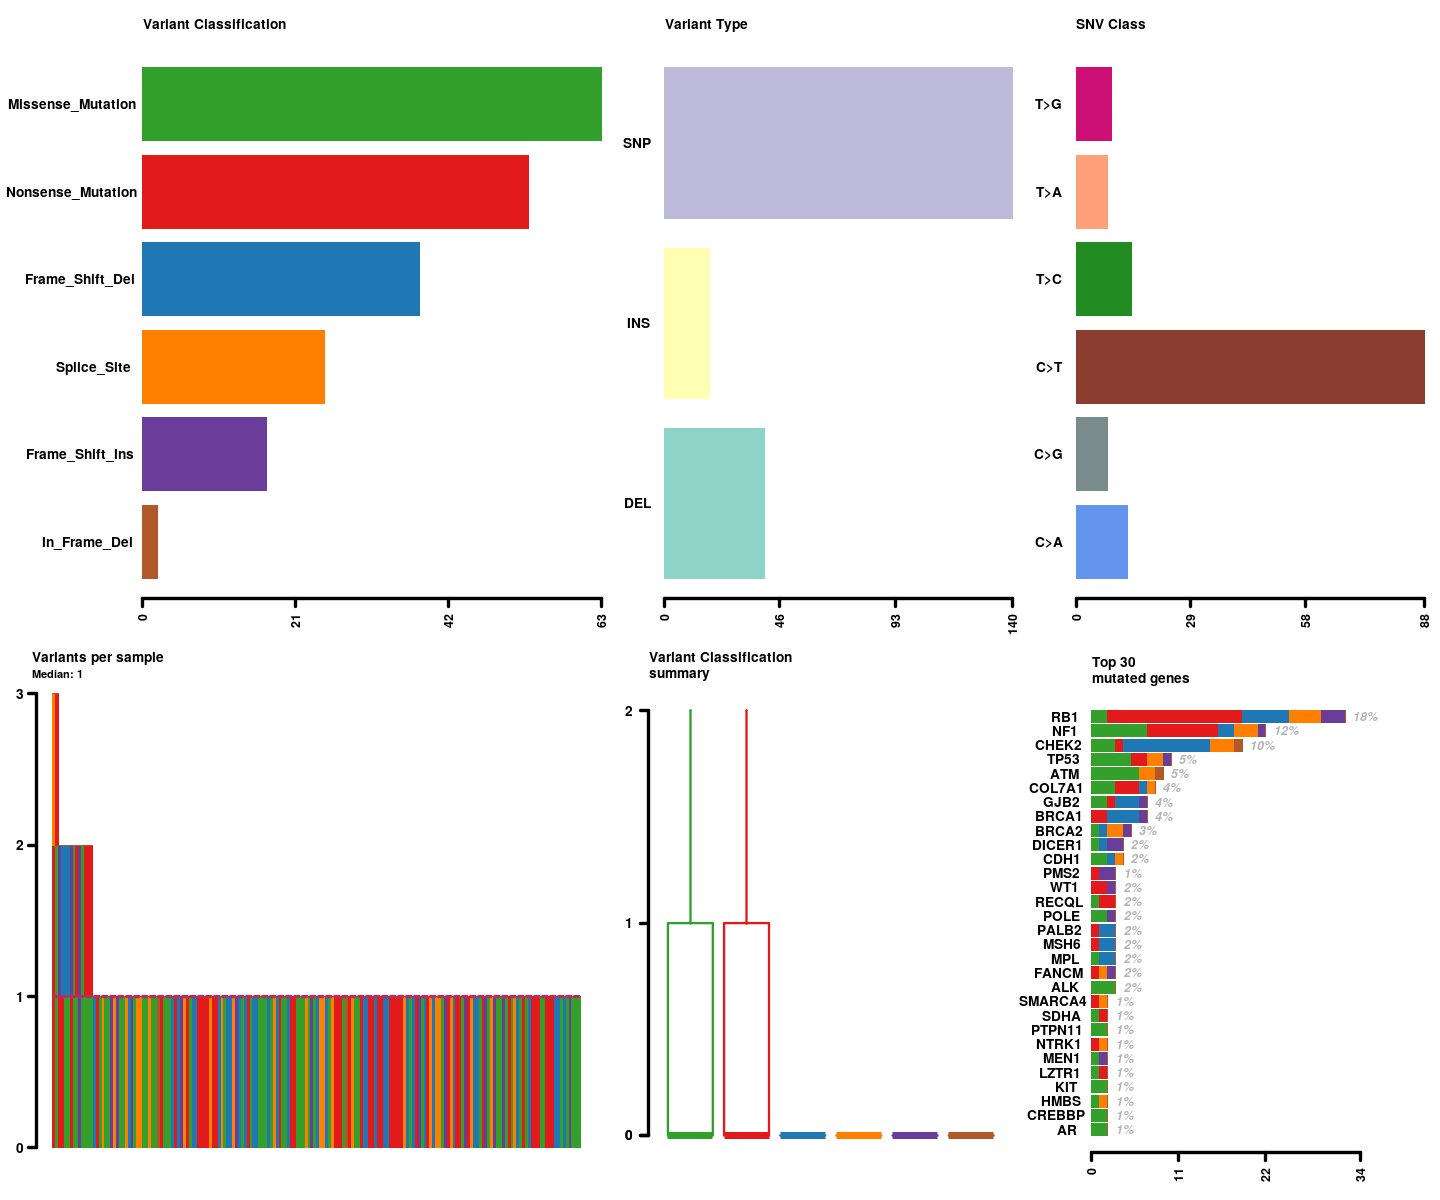

In [51]:
options(repr.plot.width=12, repr.plot.height=10)
plotmafSummary(maf = dfx, rmOutlier = FALSE ,dashboard = TRUE,addStat = 'median', textSize = 2, top = gf_sx, showBarcodes=F )
svg("../KCPG_Variants/plots/KCGP/plotmafsummary_01.svg", height=10, width=12)
plotmafSummary(maf = dfx, rmOutlier = FALSE ,dashboard = TRUE,addStat = 'median', textSize = 2, top = gf_sx, showBarcodes=F )
dev.off()

### Oncoplots or waterfall plots
- Adding Clinical Data on oncoplot

### Make Oncoplots with the total genes from the gene summary

[1] "Saving : ../KCPG_Variants/plots/KCGP/oncoplot_31stMay_01.svg"

png 
  2

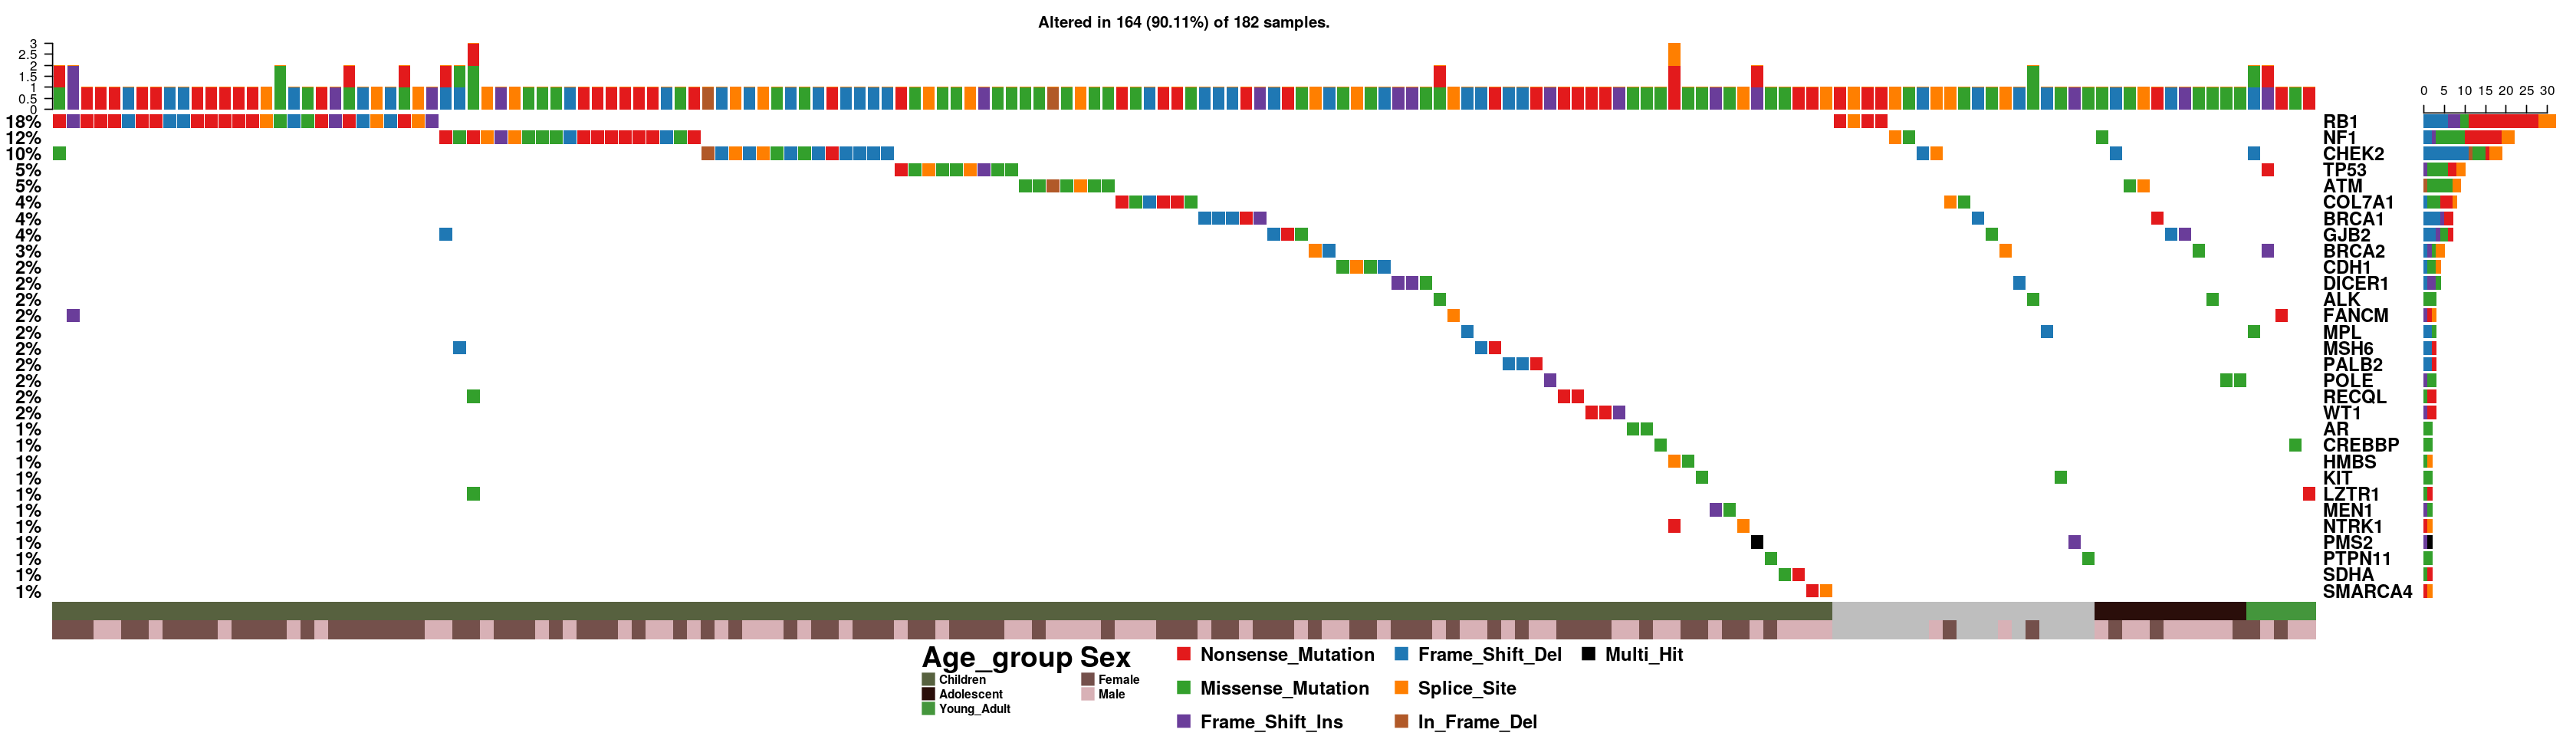

In [63]:
total_genes = len( unique(rownames(gs)))
options(repr.plot.width=28, repr.plot.height=8)
oncoplot(maf = dfx,bgCol = "white",
        top = 30,
        
        fontSize = 14,
        SampleNamefontSize = 32,
        titleFontSize = 12,
        legendFontSize = 14,
        annotationTitleFontSize = 22,
        annotationFontSize = 9,
        
        drawColBar = TRUE,
        drawRowBar = TRUE,
        showTumorSampleBarcodes = F,
        sortByAnnotation = TRUE,
        writeMatrix = FALSE,
        clinicalFeatures = c("Age_group","Sex"))

out_svg = paste0('../KCPG_Variants/plots/KCGP/oncoplot_31stMay_01.svg')
paste0("Saving : ", out_svg)
svg(out_svg, width=18, height=8)
oncoplot(maf = dfx,bgCol = "white",
        top = total_genes,
        
        fontSize = 14,
        SampleNamefontSize = 32,
        titleFontSize = 12,
        legendFontSize = 14,
        annotationTitleFontSize = 22,
        annotationFontSize = 9,
        
        drawColBar = TRUE,
        drawRowBar = TRUE,
        showTumorSampleBarcodes = F,
        sortByAnnotation = TRUE,
        writeMatrix = FALSE,
        clinicalFeatures = c("Age_group","Sex"))
dev.off()

[1] "Saving : ../KCPG_Variants/plots/KCGP/oncoplot_31stMay_01.pdf"

png 
  2

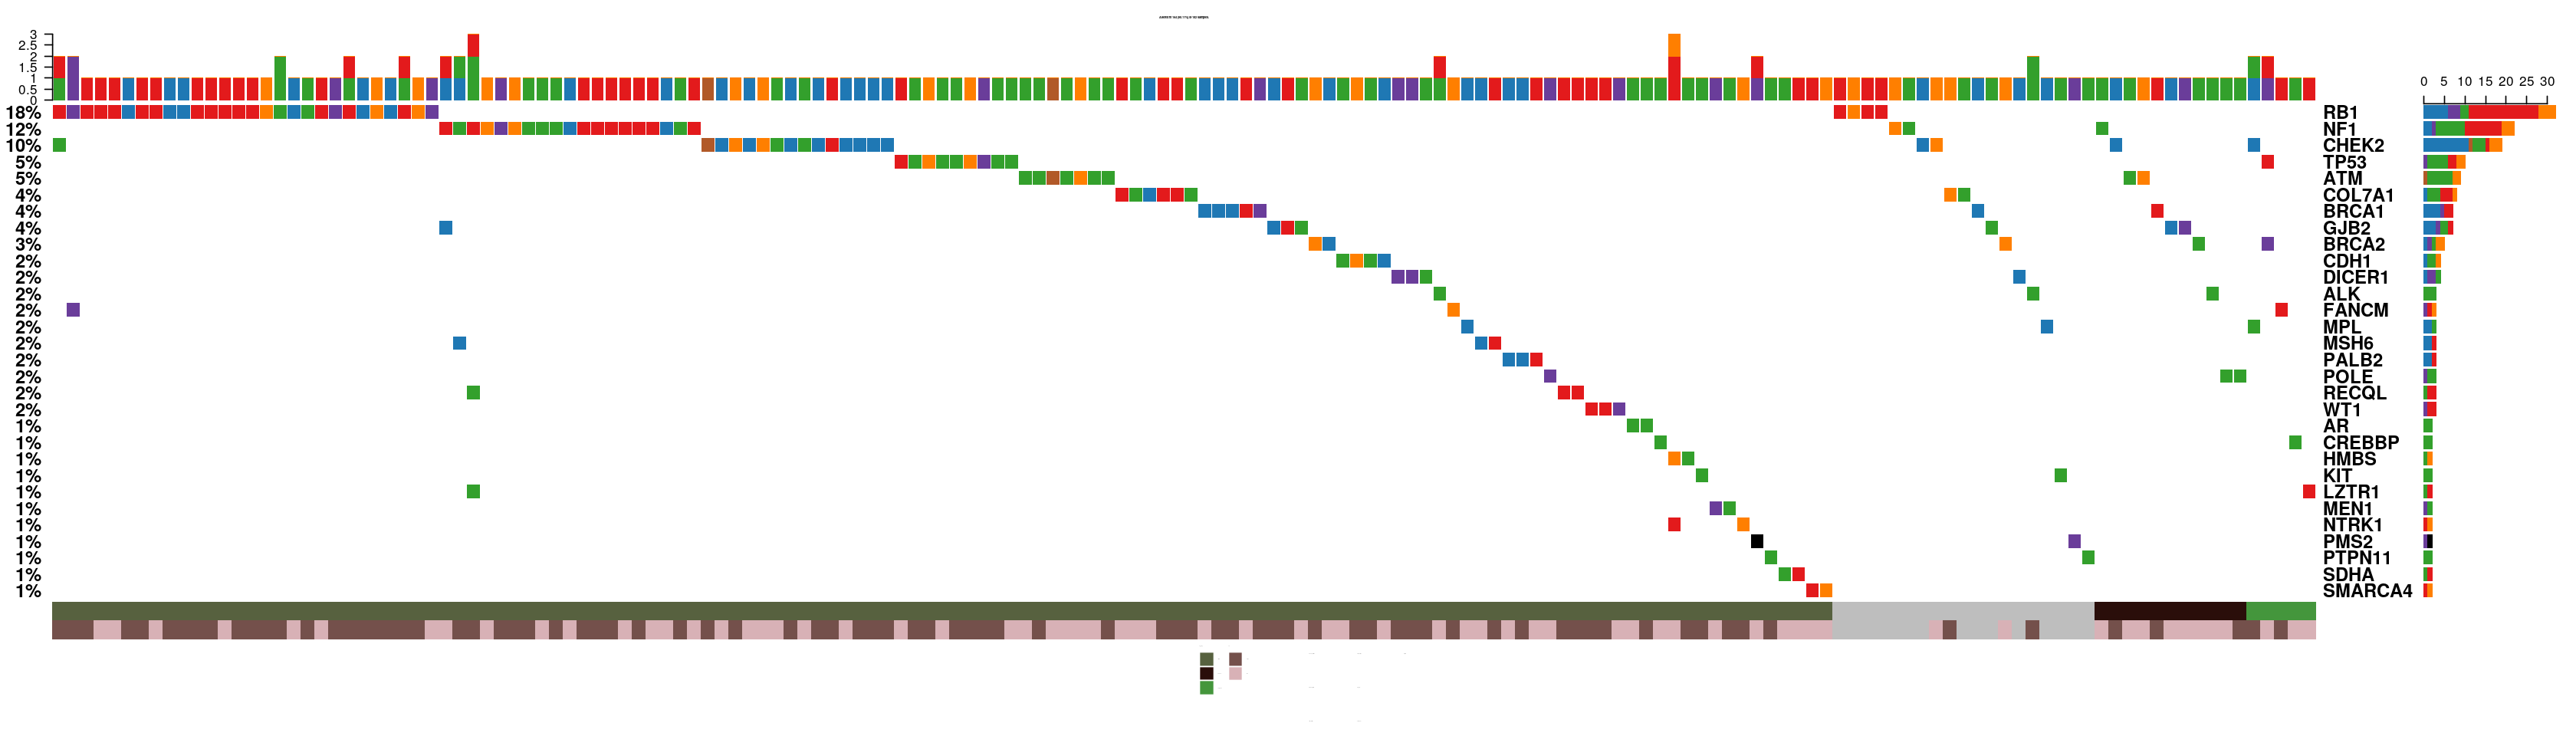

In [71]:
total_genes = len( unique(rownames(gs)))
options(repr.plot.width=28, repr.plot.height=8)
oncoplot(maf = dfx,bgCol = "white",
        top = 30,
        
        fontSize = 14,
        SampleNamefontSize = 0,
        titleFontSize = 2,
        legendFontSize = 0,
        annotationTitleFontSize = 0,
        annotationFontSize = 0,
        
        drawColBar = TRUE,
        drawRowBar = TRUE,
        showTumorSampleBarcodes = F,
        sortByAnnotation = TRUE,
        writeMatrix = FALSE,
        clinicalFeatures = c("Age_group","Sex"))

out_img = paste0('../KCPG_Variants/plots/KCGP/oncoplot_31stMay_01.pdf')
paste0("Saving : ", out_img)
pdf(out_img, width=18, height=8)
oncoplot(maf = dfx,bgCol = "white",
        top = total_genes,
        
        fontSize = 14,
        SampleNamefontSize = 0,
        titleFontSize = 2,
        legendFontSize = 0,
        annotationTitleFontSize = 0,
        annotationFontSize = 0,
        
        drawColBar = TRUE,
        drawRowBar = TRUE,
        showTumorSampleBarcodes = F,
        sortByAnnotation = TRUE,
        writeMatrix = FALSE,
        clinicalFeatures = c("Age_group","Sex"))
dev.off()